# Contents

__[1. Introduction](#Introduction)__  

__[2. Loading modules and data](#Loading-modules-and-data)__  

__[3. Preprocessing](#Preprocessing)__  

__[4. Exploratory analysis and feature engineering](#Exploratory-analysis-and-feature-engineering)__  
    [4.1. Profiling variables](#Profiling-variables)  
    [4.1. Data transformation and Clustering variables](#Data-transformation-and-Clustering-variables)

__[5. Model Selection](#Model-Selection)__  

__[6. Analysis](#Analysis)__  



# Introduction

Clustering is an unsupervised machine learning task, involving discovering groups in data. Clustering helps with pattern discovery. This project aims to use clustering approaches to perform customer segmentation on [Online Retail data](https://www.kaggle.com/datasets/vijayuv/onlineretail).


### Use cases:
- __data summarization__
    - clustering is a step for classification or outlier analysis
    - dimensionality reduction
- __collaborative filtering__
    - grouping of users with similar interests
- __customer segmentation__
    - grouping of customers
- __dynamic trend detection__
    - in social networks:  data is dynamically clustered in a streaming fashion and used to determine patterns of changes.
- __multimedia data analysis__
    - detecting similar areas in images, video, audio.
- __social network analysis__
    - detecting communities
    
### Validation  
- use __case studies__ to illustrate the subjective quality of the clusters
- __measures of the clusters__ (cluster radius or density)
    - can be biased (measures could favor different algorithms in a different way)
- labels can be given to data points - then __correlations of the clusters with the labels__ can be used
    - class labels may not always align with the natural clusters
    
    
### Approach

1. Define goals: find users that are similar in important ways to the business (producs, usage, demographics, channels, etc) and:
    - discover how business metrics differ between them.
    - use that information to improve existing models.
    - tailor marketing strategy to each customer segment.
    
    
2. Data:
    1. Behavioural data (transactions):
        - visits, usage, penetration responses, engagement, lifestyle, preferences, channel preferences, etc.
        - number of times a user purchased, how much, what products and categories.
        - number of transactions over a period of time, number of units.
    1. Additional data:
        1. User side:
            - time between purchases, categories purchased, peaks and valleys of transactions, units and revenue, share of categories, number of units and transactions per user, percentage of discounts per user, top N categories purchased per user.
        1. Company side:
            - seasonality variables, featured categories, promotions in place.
        1. Third party data:
            - demographics, interests, attitudes, lifestyles.
    

3. Implement a model:
    - model should be multivariate, multivariable, probabilistic (e.g. LCA).
    - run model (e.g. linear regression) for each segment separately, thus taking into account different user profiles.


4. Analyse returned segments:
    - some segments could be price sensitive, prefer one channel, have high penetration of a particular product, prefer a certain way of communication.
    - we expect to find a segment that is penetrated in one category, but not another.
    - profiling:
        - profile - what is shown to managers as a proof that the segments are different: 
            - KPIs.
            - indexes (e.g. take each segment's mean and divide by total mean to show how a segment is different from the rest in percentage).
    - name the segments (e.g. high revenue, low response, etc.)
    
    
5. Act based on learnt information:
    - e.g. if a segment is price sensitive, users should get a discount to motivate them to make a purchase.


__[🔼](#Contents)__  


# Loading modules and data

In [40]:
import pandas as pd
import numpy as np
from importlib import reload
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.cluster import SpectralClustering, OPTICS, MeanShift, KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

import tools as t
reload(t)

from tools.preprocessing import rfm
from tools.preprocessing import eda
from tools.preprocessing import feature_selection as fe
from tools.modeling import clustering


In [41]:
data = eda.Dataset(
    features=['StockCode', 'InvoiceDate', 'Country', 'Quantity', 'UnitPrice', 'CustomerID'],
    features_categorical=['StockCode', 'Country'],
)
print(data)

Data transformation class.         
---------------------------        
Inputted features: ['StockCode', 'InvoiceDate', 'Country', 'Quantity', 'UnitPrice', 'CustomerID'].         
---------------------------        
Transformation steps:         
1. Correct data types         
2. Feature engineering: Revenue         
3. One Hot Encoding of ['StockCode', 'Country']        


__[🔼](#Contents)__  

# Preprocessing

In [42]:
df0 = data.get_transformed()
print(df0.shape)
df0.head(9)

(541909, 11)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,InvoiceDay,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010,1,12,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010,1,12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010,1,12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010,1,12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010,1,12,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,17850,United Kingdom,2010,1,12,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850,United Kingdom,2010,1,12,25.50
7,536366,22633,HAND WARMER UNION JACK,6,1.85,17850,United Kingdom,2010,1,12,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850,United Kingdom,2010,1,12,11.10


__[🔼](#Contents)__  

# Exploratory analysis and feature engineering

## Profiling variables



In [43]:
df_profiling = data.get_profiling_df()
df_profiling

,#_stockCode,#_InvoiceNo,avgQ,avgP,avgRevenue,HighRevenueMonth,TotalRevenue,TotalQ
CustomerID,,,,,,,,
17850,312.0,35.0,5.426282,3.924712,16.950737,2.0,5288.63,1693.0
13047,196.0,18.0,6.913265,4.072959,15.709694,3.0,3079.10,1355.0
12583,251.0,18.0,19.956175,3.152510,28.634821,7.0,7187.34,5009.0
13748,28.0,5.0,15.678571,3.996429,33.866071,5.0,948.25,439.0
15100,6.0,6.0,9.666667,10.950000,105.850000,8.0,635.10,58.0
...,...,...,...,...,...,...,...,...
13436,12.0,1.0,6.333333,5.830000,16.407500,8.0,196.89,76.0
15520,18.0,1.0,17.444444,1.724444,19.083333,8.0,343.50,314.0
13298,2.0,1.0,48.000000,3.750000,180.000000,8.0,360.00,96.0


In [44]:
temp = df_profiling.query("CustomerID == 12583")
temp

,#_stockCode,#_InvoiceNo,avgQ,avgP,avgRevenue,HighRevenueMonth,TotalRevenue,TotalQ
CustomerID,,,,,,,,
12583,251.0,18.0,19.956175,3.15251,28.634821,7.0,7187.34,5009.0


In [45]:
df_profiling.dropna(inplace=True)
X = df_profiling.reset_index(drop=True)
y = df_profiling.reset_index()['CustomerID']

__[🔼](#Contents)__  

## Feature selection


In [46]:
df_clustering_lw = fe.low_variance(df_profiling, threshold=0.25) 

Dimensionality reduced from 8 to 7.


In [49]:
df_clustering_fe, mask_fe = fe.RFE_selection(X=X, y=y, n_features_to_select=1000, step=1, mask=None)

Dimensionality reduced from 9 to 8.


__[🔼](#Contents)__  

# Model Selection

In [52]:
import tools as t
reload(t)
from tools.modeling import clustering

clustering = clustering.Clustering(df_clustering_lw)

KMeans(n_clusters=3, random_state=42)


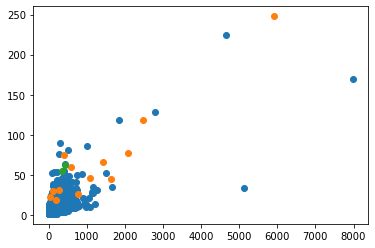

In [53]:
name = 'Kmeans'
model = KMeans(n_clusters=3, random_state=42)
steps = [
    ('PCA', PCA(n_components=2)),
    ('scaler', StandardScaler()),
]
plot=True

model_kmeans, ypred_kmeans = clustering.check_model(name, model, steps, plot)

In [61]:
df_clustering_lw['clusters'] = ypred_kmeans
df_clustering_lw

,#_stockCode,#_InvoiceNo,avgQ,avgP,avgRevenue,TotalRevenue,TotalQ,clusters
CustomerID,,,,,,,,
17850,312.0,35.0,5.426282,3.924712,16.950737,5288.63,1693.0,0
13047,196.0,18.0,6.913265,4.072959,15.709694,3079.10,1355.0,0
12583,251.0,18.0,19.956175,3.152510,28.634821,7187.34,5009.0,0
13748,28.0,5.0,15.678571,3.996429,33.866071,948.25,439.0,0
15100,6.0,6.0,9.666667,10.950000,105.850000,635.10,58.0,0
...,...,...,...,...,...,...,...,...
13436,12.0,1.0,6.333333,5.830000,16.407500,196.89,76.0,0
15520,18.0,1.0,17.444444,1.724444,19.083333,343.50,314.0,0
13298,2.0,1.0,48.000000,3.750000,180.000000,360.00,96.0,0


__[🔼](#Contents)__  

# Analysis

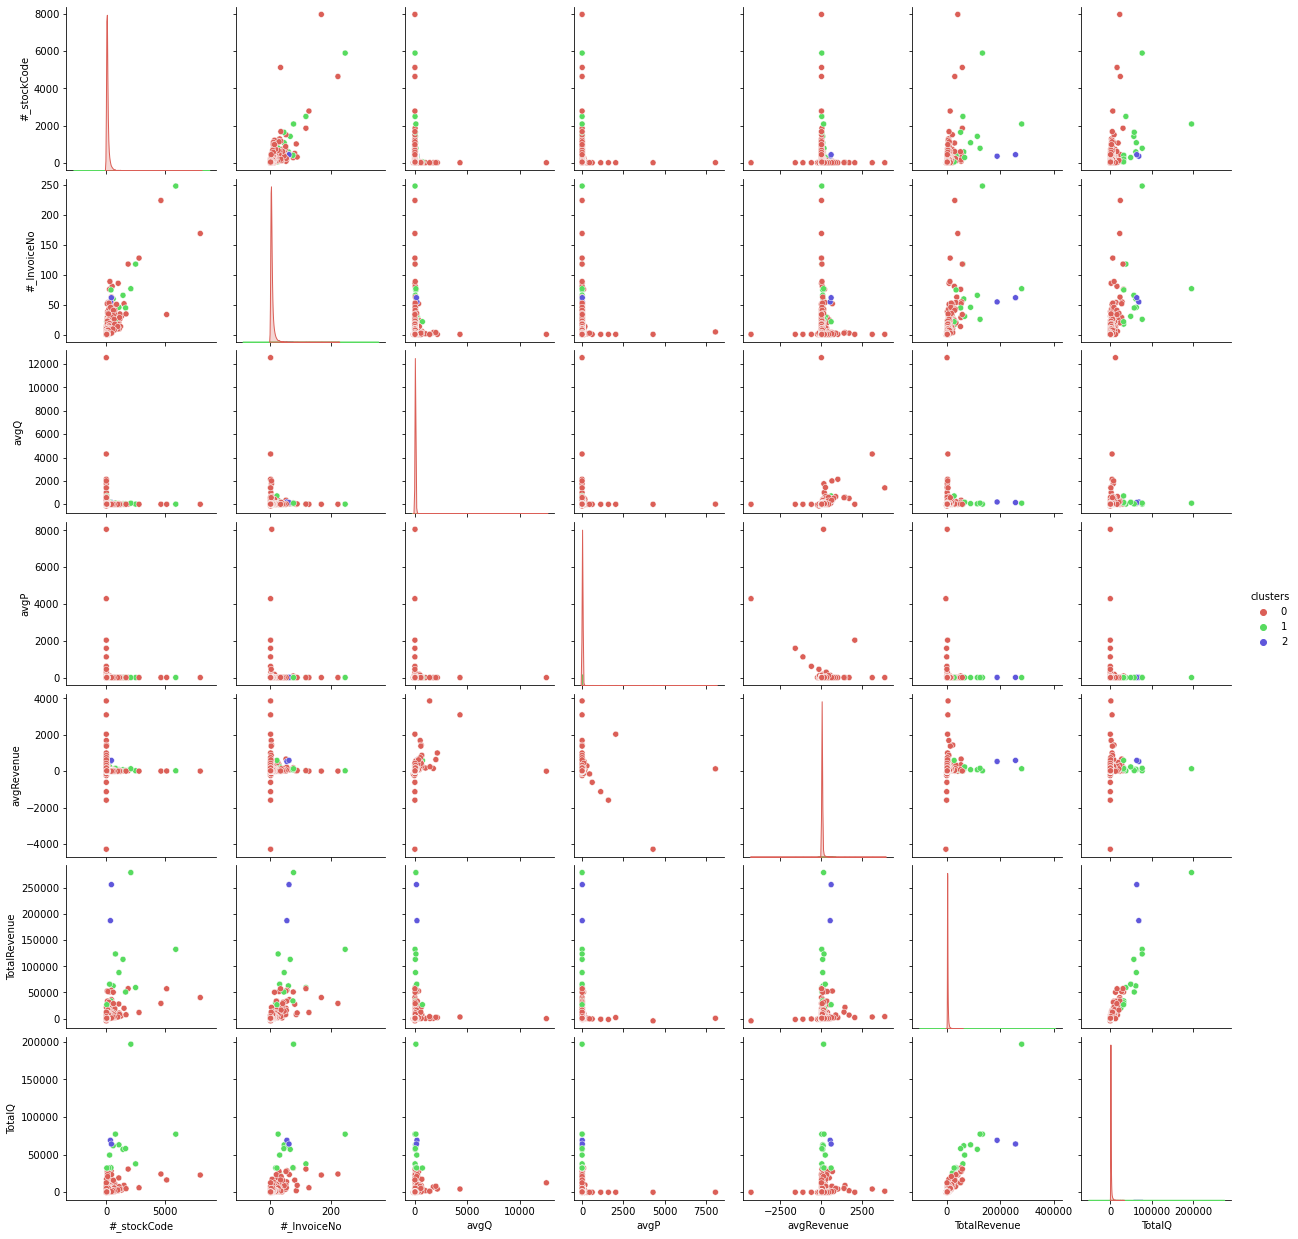

In [62]:
sns.pairplot(df_clustering_lw, 
             hue="clusters",
            palette=sns.color_palette("hls", 3))
